In [10]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import random
from sklearn.linear_model import BayesianRidge, LogisticRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold
from sklearn.svm import SVR
from mplsoccer import Pitch, VerticalPitch
from IPython.display import set_matplotlib_formats
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neural_network import MLPClassifier
import plotly.express as px
from xgboost import XGBRegressor

set_matplotlib_formats('retina')

/var/folders/yn/w3h701111q199y7qdtvn61940000gn/T/ipykernel_8847/646339800.py:23: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina')


In [11]:
# Load datasets
damallsvenskan = pd.read_csv('csv/damallsvenskan_all.csv')
allsvenskan = pd.read_csv('csv/allsvenskan_all.csv')

# Add an identifier column for each dataframe
allsvenskan['league'] = 'allsvenskan'
damallsvenskan['league'] = 'damallsvenskan'

# Concatenate the two datasets
both = pd.concat([allsvenskan, damallsvenskan])

In [12]:
# Create a column to identify if the next action is a goal
both['is_next_goal'] = (both['action'].shift(-1) == 'Goal').astype(int)

# Identify shots and whether they resulted in a goal
both['is_shot'] = (both['action'] == 'Shot').astype(int)
shots = both[both['is_shot'] == 1]

# Scale coordinates
scale_x = lambda x: x * 120 / 100
scale_y = lambda y: y * 80 / 100
shots['x'] = shots['xpos'].apply(scale_x)
shots['y'] = shots['ypos'].apply(scale_y)

# Convert 'is_next_goal' to boolean and select relevant columns
shots['goal'] = shots['is_next_goal'].astype(bool)
shots = shots[['x', 'y', 'goal', 'league', 'header', 'penalty', 'attack_type']]

# If attacktype = NaN, set it to 'Open Play'
shots['attack_type'] = shots['attack_type'].fillna('Open Play')

# Apply angle and distance calculations
def calculate_angle(x, y):
    width = 7.32
    new_x = 120 - x
    new_y = abs(y - 40)
    tan_theta = (width * new_x) / (new_x**2 + new_y**2 - (width/2)**2)
    theta = np.arctan(tan_theta) * (180 / np.pi)  # Convert radians to degrees
    return theta

def calculate_dist(x, y):
    return np.sqrt((120 - x)**2 + (40 - y)**2)

shots['angle'] = shots.apply(lambda row: calculate_angle(row['x'], row['y']), axis=1)
shots['distance'] = shots.apply(lambda row: calculate_dist(row['x'], row['y']), axis=1)

# Split the data based on league
allsvenskan_shots = shots[shots['league'] == 'allsvenskan']
damallsvenskan_shots = shots[shots['league'] == 'damallsvenskan']

# Prepare the features and labels
X_allsvenskan = allsvenskan_shots[['distance', 'angle', 'penalty', 'header', 'attack_type']]
y_allsvenskan = allsvenskan_shots['goal'].astype(int)

X_damallsvenskan = damallsvenskan_shots[['distance', 'angle', 'penalty', 'header', 'attack_type']]
y_damallsvenskan = damallsvenskan_shots['goal'].astype(int)

X_allsvenskan = pd.get_dummies(X_allsvenskan, columns=['attack_type'])
X_damallsvenskan = pd.get_dummies(X_damallsvenskan, columns=['attack_type'])

# Remove attack_type_Penalty from the features
X_allsvenskan = X_allsvenskan.drop(columns=['attack_type_Penalty'])
X_damallsvenskan = X_damallsvenskan.drop(columns=['attack_type_Penalty'])

# Print the datafram containing the distance, angle, header and penalty columns
X_allsvenskan.head(50)

/var/folders/yn/w3h701111q199y7qdtvn61940000gn/T/ipykernel_8847/4117524235.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shots['x'] = shots['xpos'].apply(scale_x)
/var/folders/yn/w3h701111q199y7qdtvn61940000gn/T/ipykernel_8847/4117524235.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shots['y'] = shots['ypos'].apply(scale_y)
/var/folders/yn/w3h701111q199y7qdtvn61940000gn/T/ipykernel_8847/4117524235.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

,distance,angle,penalty,header,attack_type_Corner,attack_type_Counter,attack_type_Free-kick,attack_type_Open Play,attack_type_Throw-in
74,18.646179,13.305603,False,False,False,False,False,True,False
106,17.366635,12.043411,False,False,False,False,False,True,False
114,23.637259,16.169050,False,False,False,False,False,True,False
163,6.053098,62.110234,False,True,False,False,False,True,False
269,27.888349,14.805480,False,False,False,False,False,True,False
337,17.366635,12.043411,False,False,False,False,False,True,False
353,4.326662,78.577219,False,True,True,False,False,False,False
428,15.388307,13.274114,False,False,False,True,False,False,False
453,15.681837,26.155509,False,False,False,False,False,True,False
483,13.440238,25.299982,False,False,False,False,False,False,True


In [13]:
# Now, depending on your choice, you can set the training and test sets as follows:
# For training with allsvenskan and testing with damallsvenskan
#X_train, y_train = X_allsvenskan, y_allsvenskan
#X_test, y_test = X_damallsvenskan, y_damallsvenskan

# Alternatively, for training with damallsvenskan and testing with damallsvenskan
#X_train, y_train = X_damallsvenskan, y_damallsvenskan
#X_test, y_test = X_allsvenskan, y_allsvenskan

# Alternatively, for training with allsvenskan+damallsvenskan and testing with allsvenskan+damallsvenskan
X_train, y_train = pd.concat([X_allsvenskan, X_damallsvenskan]), pd.concat([y_allsvenskan, y_damallsvenskan])
X_test, y_test = pd.concat([X_allsvenskan, X_damallsvenskan]), pd.concat([y_allsvenskan, y_damallsvenskan])

## Support Vector Machine

In [14]:
# Initialize the SVR model with a pipeline
svm_model = make_pipeline(StandardScaler(), SVR())

# Use K-Fold for cross-validation in a regression task
cv = KFold(n_splits=5)

# Cross-validation across the entire dataset for MSE estimation
cv_mse_svm = -cross_val_score(svm_model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error').mean()
print(f'Cross-Validated Mean Squared Error: {cv_mse_svm}')

# Fit the model on the training data
svm_model.fit(X_train, y_train)

# Predictions
y_pred = svm_model.predict(X_test)

# Evaluate the model using regression metrics
mae_svm = mean_absolute_error(y_test, y_pred)
mse_svm = mean_squared_error(y_test, y_pred)
rmse_svm = np.sqrt(mse_svm)  # Calculating RMSE
r2_svm = r2_score(y_test, y_pred)

# Print the evaluation metrics
print(f'Mean Absolute Error (MAE): {mae_svm}')
print(f'Mean Squared Error (MSE): {mse_svm}')
print(f'Root Mean Squared Error (RMSE): {rmse_svm}')
print(f'R-squared (R²): {r2_svm}')

Cross-Validated Mean Squared Error: 0.08699001093847267
Mean Absolute Error (MAE): 0.17807656646694636
Mean Squared Error (MSE): 0.08659307408361114
Root Mean Squared Error (RMSE): 0.29426701154497614
R-squared (R²): 0.096250549385404


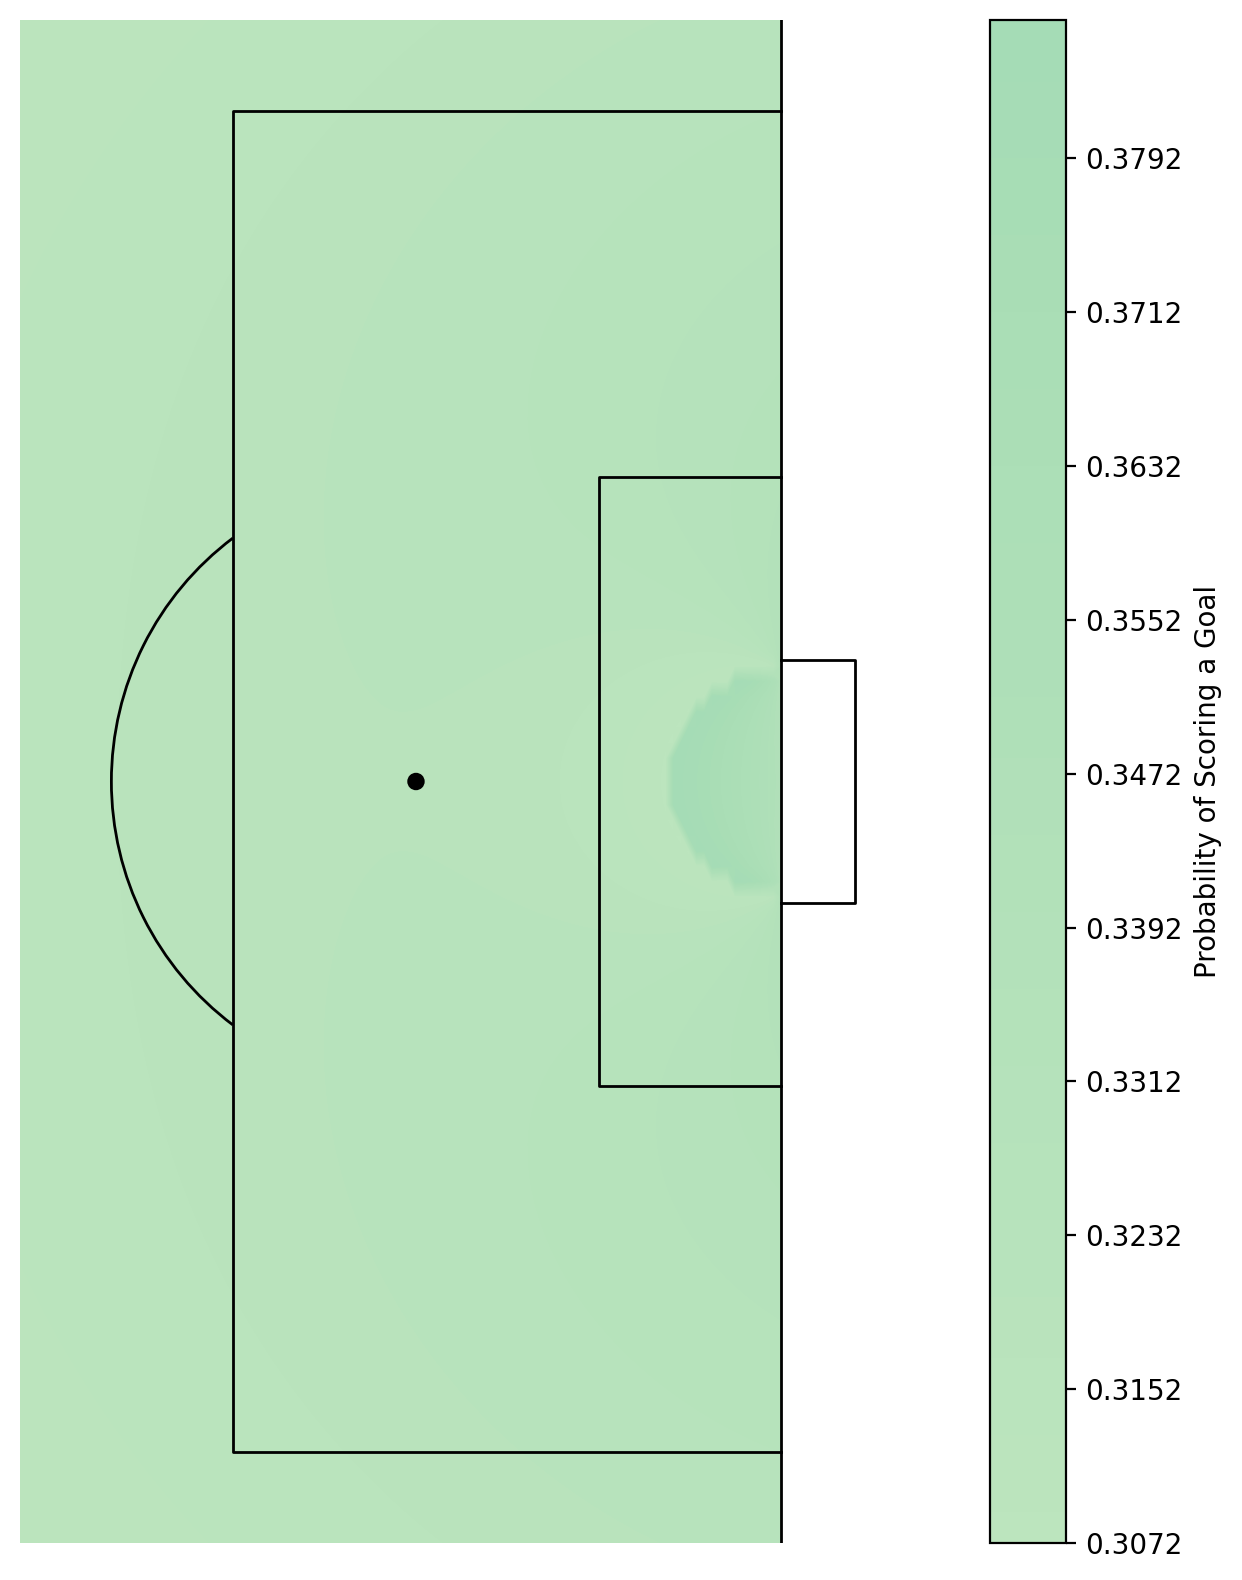

In [15]:
# Adjusted grid for higher resolution
x_values = np.linspace(95, 120, 100)  # Increase the number of points for finer resolution
y_values = np.linspace(15, 65, 100)   # Increase the number of points for finer resolution
xx, yy = np.meshgrid(x_values, y_values)
grid_points = np.c_[xx.ravel(), yy.ravel()]

# Assuming header is binary, let's add header = 0 for non-header attempts
# Update this line to create a full feature set including the header
# For simplicity, this example assumes all attempts are non-header. Adjust if needed.
full_grid_points = np.array([[calculate_dist(x, y), calculate_angle(x, y), 0, 0, 0, 0, 0, 1, 0] for x, y in grid_points])  # Assuming header=0

# Scale the features as before and predict goal probabilities
scaled_full_grid_points = svm_model.named_steps['standardscaler'].transform(full_grid_points)  # Use fitted scaler
goal_predictions = svm_model.predict(scaled_full_grid_points)  # Regression predictions

# Clip values to be within 0 and 1
goal_predictions = np.clip(goal_predictions, 0, 1)

# Reshape for plotting
goal_pred_matrix = goal_predictions.reshape(xx.shape)

# Plotting with increased resolution
fig, ax = plt.subplots(figsize=(12, 8))
pitch = Pitch(half=True, goal_type='box', line_zorder=2, line_color='black', linewidth=1)
pitch.draw(ax=ax)
contour = ax.contourf(xx, yy, goal_pred_matrix, cmap='GnBu', levels=100, zorder=1, vmin=0, vmax=1)  # Set vmin and vmax for color scale
fig.colorbar(contour, ax=ax, label='Probability of Scoring a Goal')

# Zoom in to the penalty area
ax.set_xlim(95, 123)
ax.set_ylim(15, 65)

# Adjust layout and save the figure before plt.show()
plt.tight_layout()
plt.savefig('img_models/svm_model_heatmap.png', bbox_inches='tight')

plt.show()

## Decision Tree 

In [16]:
# Initialize the Decision Tree model
tree_model = DecisionTreeRegressor(max_depth=5)

# Use Stratified K-Fold for cross-validation
cv = StratifiedKFold(n_splits=5)

# Cross-validation across the entire dataset for a general accuracy estimation
cv_mse_dt = -cross_val_score(tree_model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error').mean()
print(f'Cross-Validated Mean Squared Error: {cv_mse_dt}')

# Fit the model on the training data
tree_model.fit(X_train, y_train)

# Predictions
y_pred = tree_model.predict(X_test)

# Evaluate the model
mse_dt = mean_squared_error(y_test, y_pred)
mae_dt = mean_absolute_error(y_test, y_pred)
rmse_dt = np.sqrt(mse_dt)
r2_dt = r2_score(y_test, y_pred)

# Print the evaluation metrics
print(f'Mean Absolute Error (MAE): {mae_dt}')
print(f'Mean Squared Error (MSE): {mse_dt}')
print(f'Root Mean Squared Error (RMSE): {rmse_dt}')
print(f'R-squared (R²): {r2_dt}')

Cross-Validated Mean Squared Error: 0.0809755159250739
Mean Absolute Error (MAE): 0.16069886235888878
Mean Squared Error (MSE): 0.0803494311794444
Root Mean Squared Error (RMSE): 0.28345975230964343
R-squared (R²): 0.16141383067769333


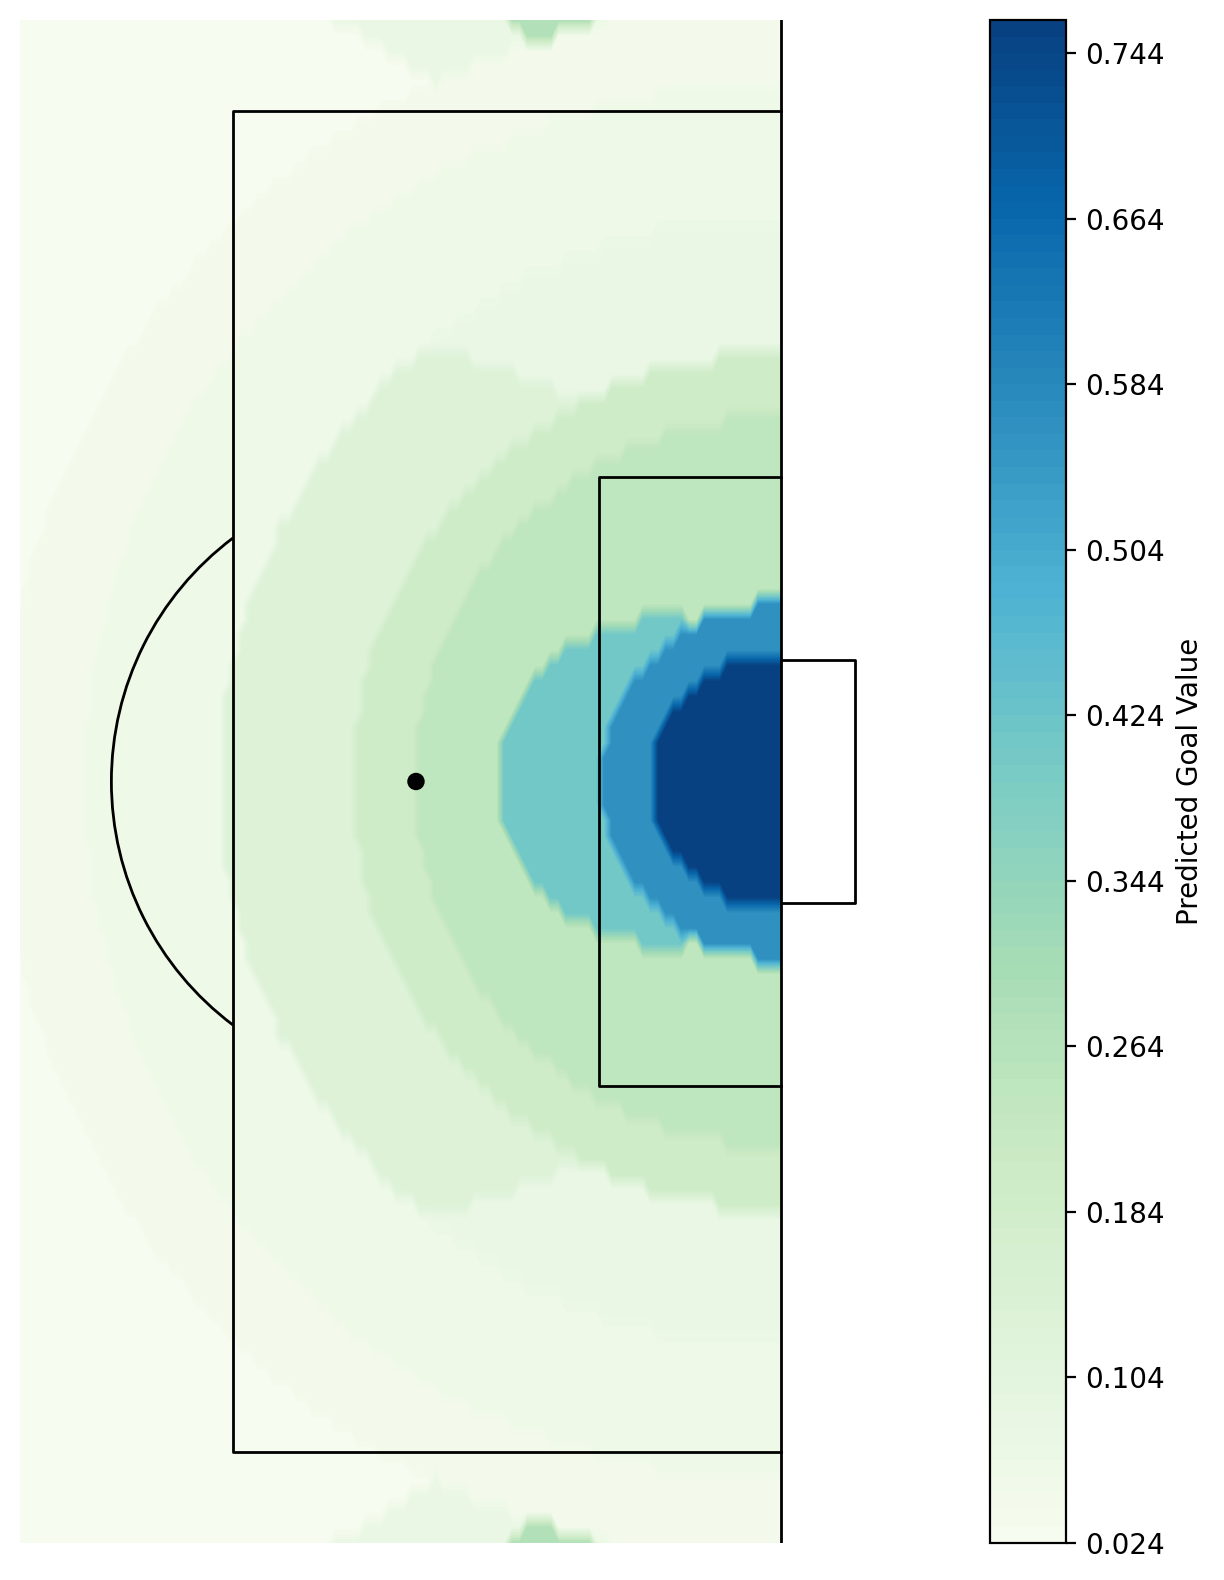

In [17]:
# Plot
x_values = np.linspace(95, 120, 100)  # Increase the number of points for finer resolution
y_values = np.linspace(15, 65, 100)   # Increase the number of points for finer resolution

xx, yy = np.meshgrid(x_values, y_values)
grid_points = np.c_[xx.ravel(), yy.ravel()]
full_grid_points = np.array([[calculate_dist(x, y), calculate_angle(x, y), 0, 0, 0, 0, 0, 1, 0] for x, y in grid_points])

# Calculate predictions instead of probabilities
goal_predictions = tree_model.predict(full_grid_points)

# Clip values to be within 0 and 1
goal_predictions = np.clip(goal_predictions, 0, 1)

goal_pred_matrix = goal_predictions.reshape(xx.shape)

fig, ax = plt.subplots(figsize=(12, 8))
pitch = Pitch(half=True, goal_type='box', line_zorder=2, line_color='black', linewidth=1)
pitch.draw(ax=ax)
contour = ax.contourf(xx, yy, goal_pred_matrix, cmap='GnBu', levels=100, zorder=1)  # Increase levels for smoother gradient
fig.colorbar(contour, ax=ax, label='Predicted Goal Value')
ax.set_xlim(95, 123)
ax.set_ylim(15, 65)
# Adjust layout and save the figure before plt.show()
plt.tight_layout()
plt.savefig('img_models/dt_model_heatmap.png', bbox_inches='tight')
plt.show()

## Random Forest

In [18]:
forest_model = RandomForestRegressor(n_estimators=100, max_depth=5)

# Use K-Fold for cross-validation in a regression task
cv = KFold(n_splits=5)

# Cross-validation across the entire dataset for MSE estimation
cv_mse_rm = -cross_val_score(forest_model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error').mean()
print(f'Cross-Validated Mean Squared Error: {cv_mse_rm}')

# Fit the model on the training data
forest_model.fit(X_train, y_train)

# Predictions
y_pred = forest_model.predict(X_test)

# Evaluate the model using regression metrics
mae_rm = mean_absolute_error(y_test, y_pred)
mse_rm = mean_squared_error(y_test, y_pred)
rmse_rm = np.sqrt(mse_rm)  # Calculating RMSE
r2_rm = r2_score(y_test, y_pred)

# Print the evaluation metrics
print(f'Mean Absolute Error (MAE): {mae_rm}')
print(f'Mean Squared Error (MSE): {mse_rm}')
print(f'Root Mean Squared Error (RMSE): {rmse_rm}')
print(f'R-squared (R²): {r2_rm}')

Cross-Validated Mean Squared Error: 0.08052943135920752
Mean Absolute Error (MAE): 0.16068434362269968
Mean Squared Error (MSE): 0.07990055628258562
Root Mean Squared Error (RMSE): 0.2826668644934981
R-squared (R²): 0.1660986215310486


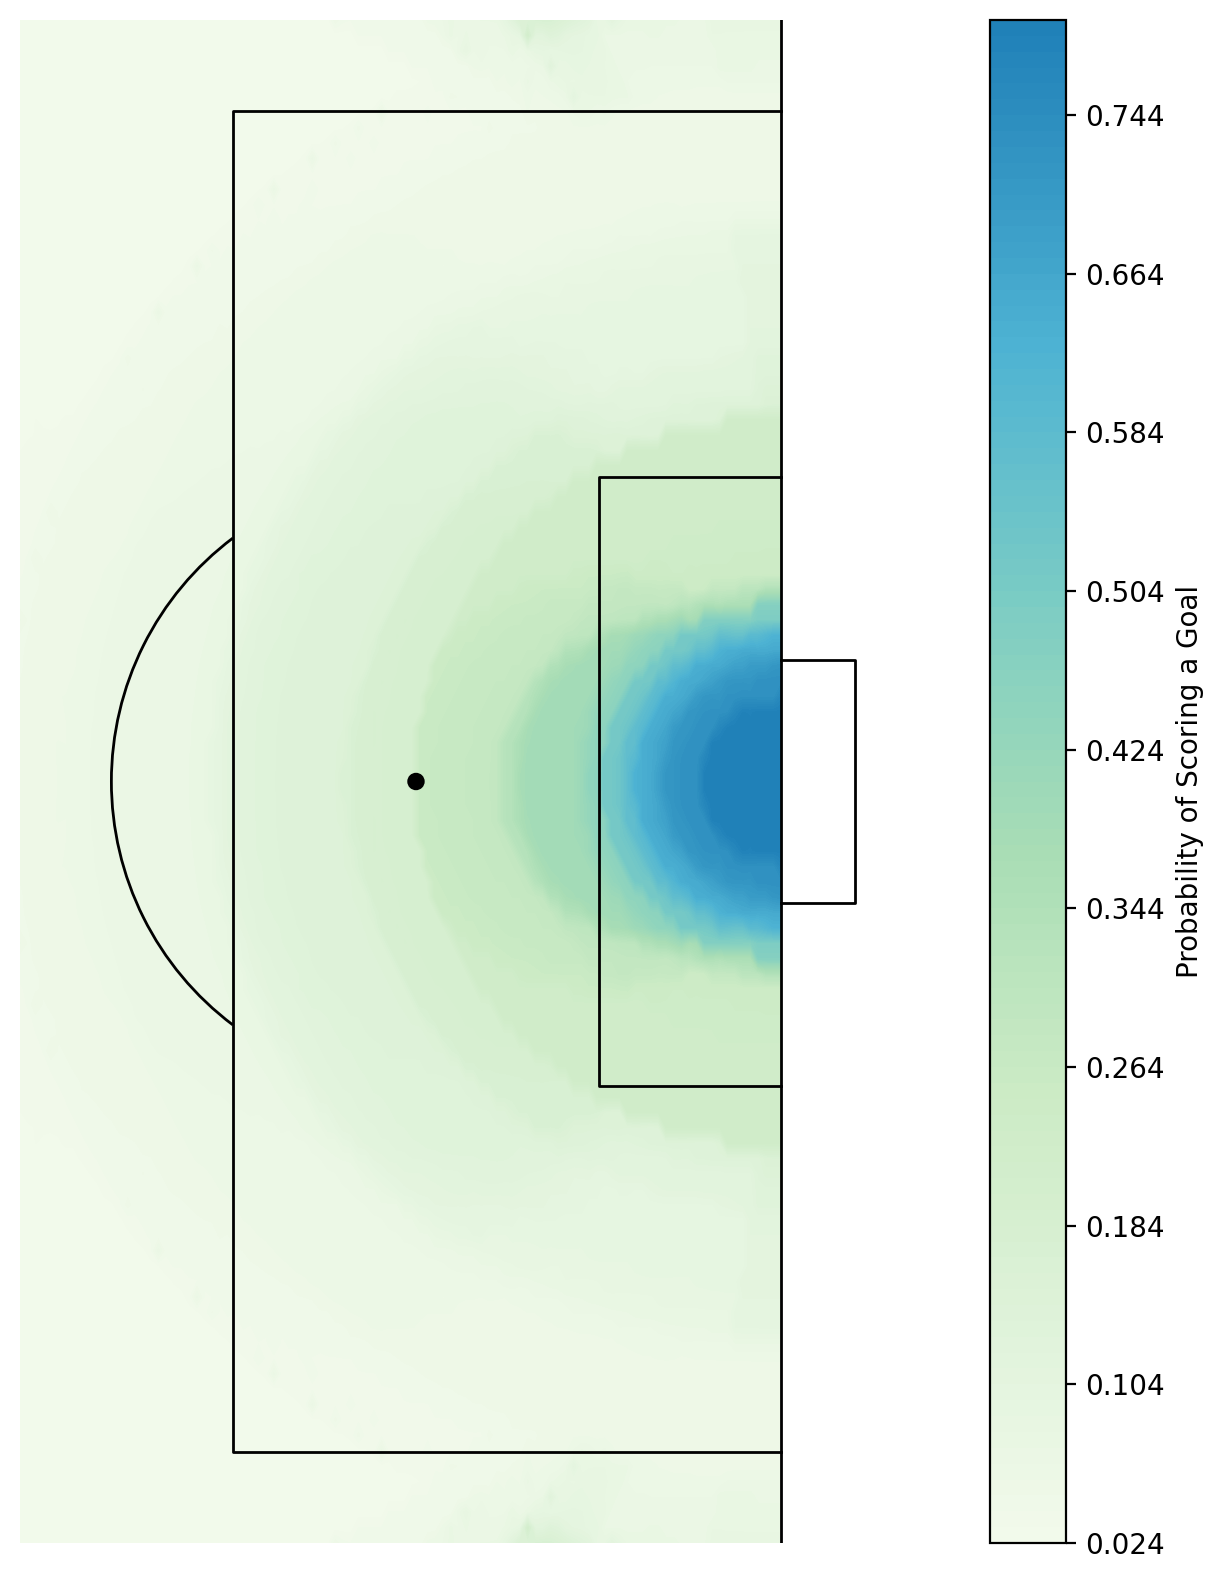

In [19]:
# Plot
x_values = np.linspace(95, 120, 100)  # Increase the number of points for finer resolution
y_values = np.linspace(15, 65, 100)   # Increase the number of points for finer resolution

xx, yy = np.meshgrid(x_values, y_values)
grid_points = np.c_[xx.ravel(), yy.ravel()]
full_grid_points = np.array([[calculate_dist(x, y), calculate_angle(x, y), 0, 0, 0, 0, 0, 1, 0] for x, y in grid_points])

# Calculate predictions instead of probabilities
goal_predictions = forest_model.predict(full_grid_points)

# Clip values to be within 0 and 1
goal_predictions = np.clip(goal_predictions, 0, 1)

goal_pred_matrix = goal_predictions.reshape(xx.shape)

fig, ax = plt.subplots(figsize=(12, 8))
pitch = Pitch(half=True, goal_type='box', line_zorder=2, line_color='black', linewidth=1)
pitch.draw(ax=ax)
contour = ax.contourf(xx, yy, goal_pred_matrix, cmap='GnBu', levels=100, zorder=1, vmin=0, vmax=1)  # Increase levels for smoother gradient
fig.colorbar(contour, ax=ax, label='Probability of Scoring a Goal')
ax.set_xlim(95, 123)
ax.set_ylim(15, 65)
# Adjust layout and save the figure before plt.show()
plt.tight_layout()
plt.savefig('img_models/rf_model_heatmap.png', bbox_inches='tight')
plt.show()

## Neural Network

In [20]:
# Initialize the Neural Network model for regression
nn_model = MLPRegressor(hidden_layer_sizes=(100, 100), max_iter=1000)

# Use K-Fold for cross-validation in a regression task
cv = KFold(n_splits=5)

# Note: Cross-validating neural networks can be computationally expensive, so adjust n_splits accordingly

# Cross-validation across the entire dataset for MSE estimation
cv_mse_nn = -cross_val_score(nn_model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error').mean()
print(f'Cross-Validated Mean Squared Error: {cv_mse_nn}')

# Fit the model on the training data
nn_model.fit(X_train, y_train)

# Predictions
y_pred = nn_model.predict(X_test)

# Evaluate the model using regression metrics
mae_nn = mean_absolute_error(y_test, y_pred)
mse_nn = mean_squared_error(y_test, y_pred)
rmse_nn = np.sqrt(mse_nn)  # Calculating RMSE
r2_nn = r2_score(y_test, y_pred)

# Print the evaluation metrics
print(f'Mean Absolute Error (MAE): {mae_nn}')
print(f'Mean Squared Error (MSE): {mse_nn}')
print(f'Root Mean Squared Error (RMSE): {rmse_nn}')
print(f'R-squared (R²): {r2_nn}')

Cross-Validated Mean Squared Error: 0.09174765028214775
Mean Absolute Error (MAE): 0.14072131637385377
Mean Squared Error (MSE): 0.08150930217305614
Root Mean Squared Error (RMSE): 0.28549834005306607
R-squared (R²): 0.14930855800602127


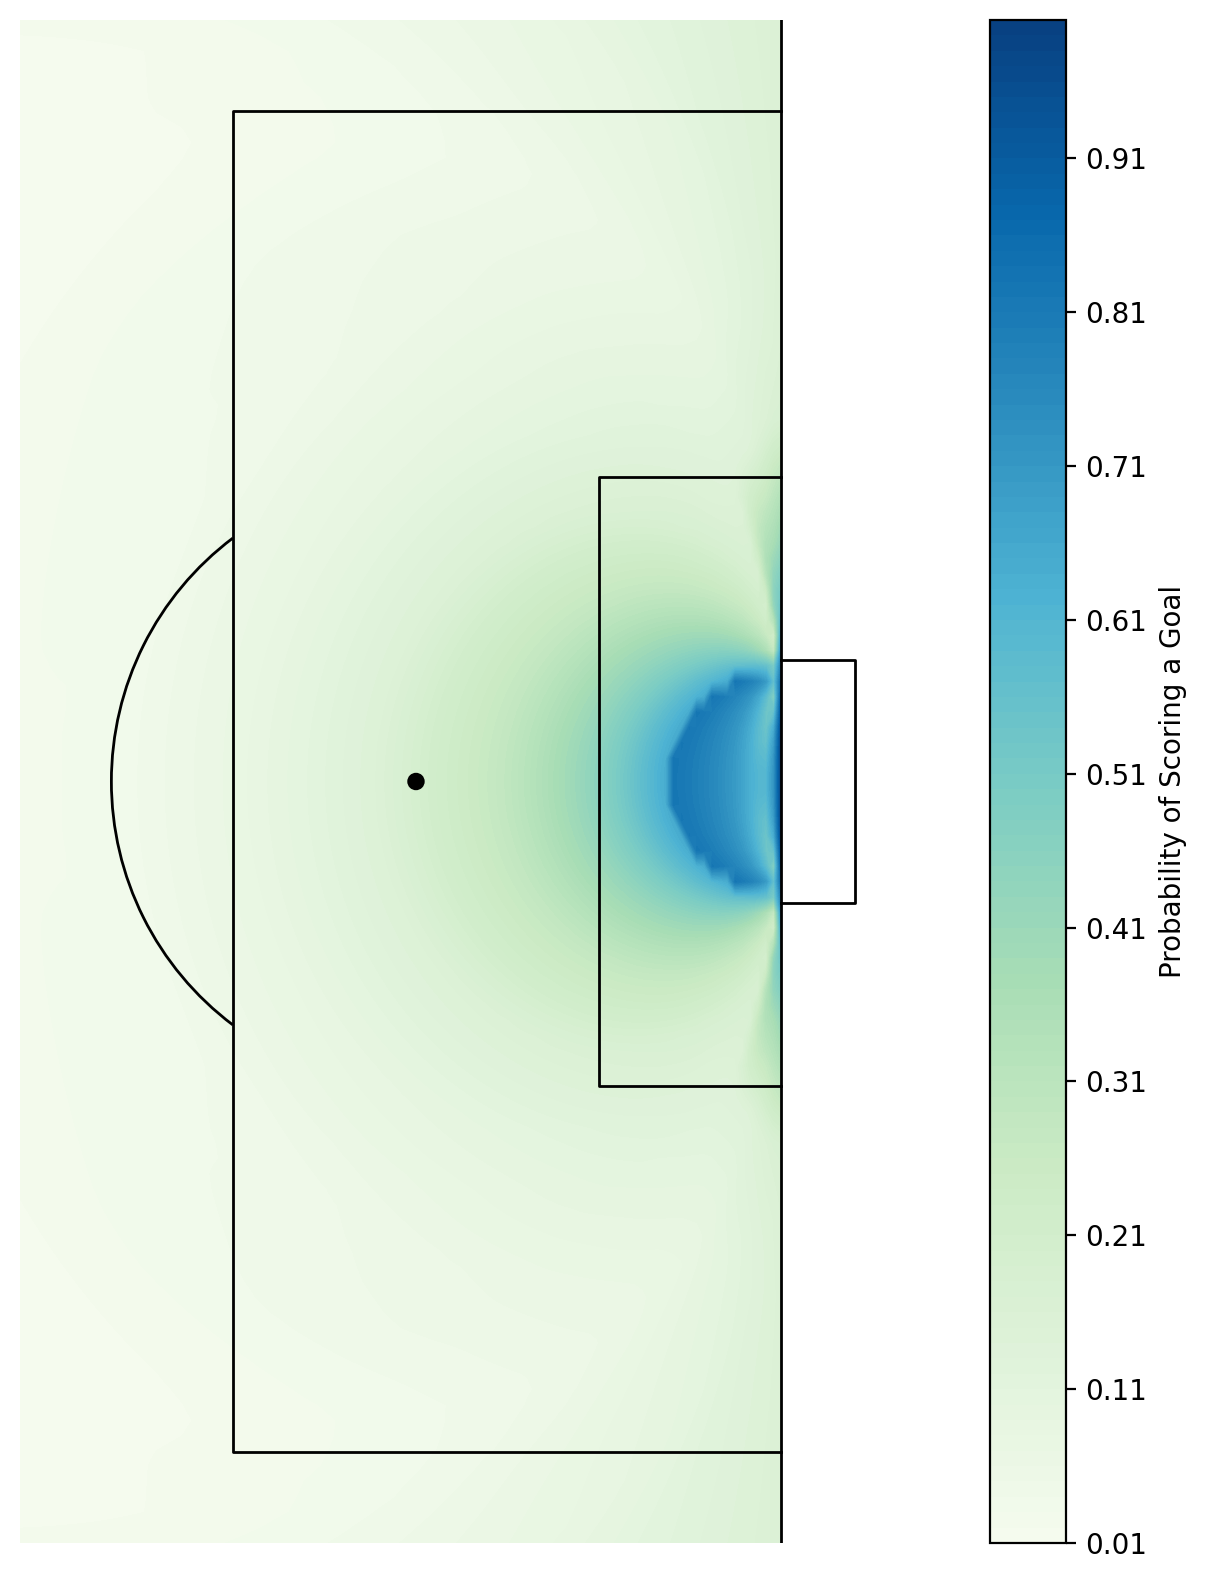

In [21]:
# Plot 
x_values = np.linspace(95, 120, 100)  # Increase the number of points for finer resolution
y_values = np.linspace(15, 65, 100)   # Increase the number of points for finer resolution

xx, yy = np.meshgrid(x_values, y_values)
grid_points = np.c_[xx.ravel(), yy.ravel()]
full_grid_points = np.array([[calculate_dist(x, y), calculate_angle(x, y), 0, 0, 0, 0, 0, 1, 0] for x, y in grid_points])

# Calculate predictions instead of probabilities
goal_predictions = nn_model.predict(full_grid_points)

# Clip values to be within 0 and 1
goal_predictions = np.clip(goal_predictions, 0, 1)

goal_pred_matrix = goal_predictions.reshape(xx.shape)

fig, ax = plt.subplots(figsize=(12, 8))
pitch = Pitch(half=True, goal_type='box', line_zorder=2, line_color='black', linewidth=1)
pitch.draw(ax=ax)
contour = ax.contourf(xx, yy, goal_pred_matrix, cmap='GnBu', levels=100, zorder=1, vmin=0, vmax=1)  # Increase levels for smoother gradient
fig.colorbar(contour, ax=ax, label='Probability of Scoring a Goal')
ax.set_xlim(95, 123)
ax.set_ylim(15, 65)
# Adjust layout and save the figure before plt.show()
plt.tight_layout()
plt.savefig('img_models/nn_model_heatmap.png', bbox_inches='tight')
plt.show()

## Logistic Regression

In [22]:
# Initialize the Logistic Regression model
log_model = LogisticRegression(max_iter=1000)  # Adjust max_iter if needed for convergence

# Use K-Fold for cross-validation, more suitable for regression-like evaluation
cv = KFold(n_splits=5)

# Note: While logistic regression is typically used for classification, here we are interested in the predicted probabilities as continuous outcomes.
# Cross-validation to estimate model performance; we use 'neg_mean_squared_error' to stay consistent with regression evaluation
cv_neg_mse_log = cross_val_score(log_model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error').mean()
cv_mse_log = -cv_neg_mse_log  # Convert to positive value
print(f'Cross-Validated Mean Squared Error: {cv_mse_log}')

# Fit the model on the training data
log_model.fit(X_train, y_train)

# Predictions - get probabilities for the positive class
y_pred_proba = log_model.predict_proba(X_test)[:, 1]

# Evaluate the model using regression metrics for the predicted probabilities
mae_log = mean_absolute_error(y_test, y_pred_proba)
mse_log = mean_squared_error(y_test, y_pred_proba)
rmse_log = np.sqrt(mse_log)  # Calculating RMSE
r2_log = r2_score(y_test, y_pred_proba)

# Print the evaluation metrics
print(f'Mean Absolute Error (MAE): {mae_log}')
print(f'Mean Squared Error (MSE): {mse_log}')
print(f'Root Mean Squared Error (RMSE): {rmse_log}')
print(f'R-squared (R²): {r2_log}')

Cross-Validated Mean Squared Error: 0.1006384092098378
Mean Absolute Error (MAE): 0.16454605134327027
Mean Squared Error (MSE): 0.08136497181461315
Root Mean Squared Error (RMSE): 0.2852454588851734
R-squared (R²): 0.15081489651554136


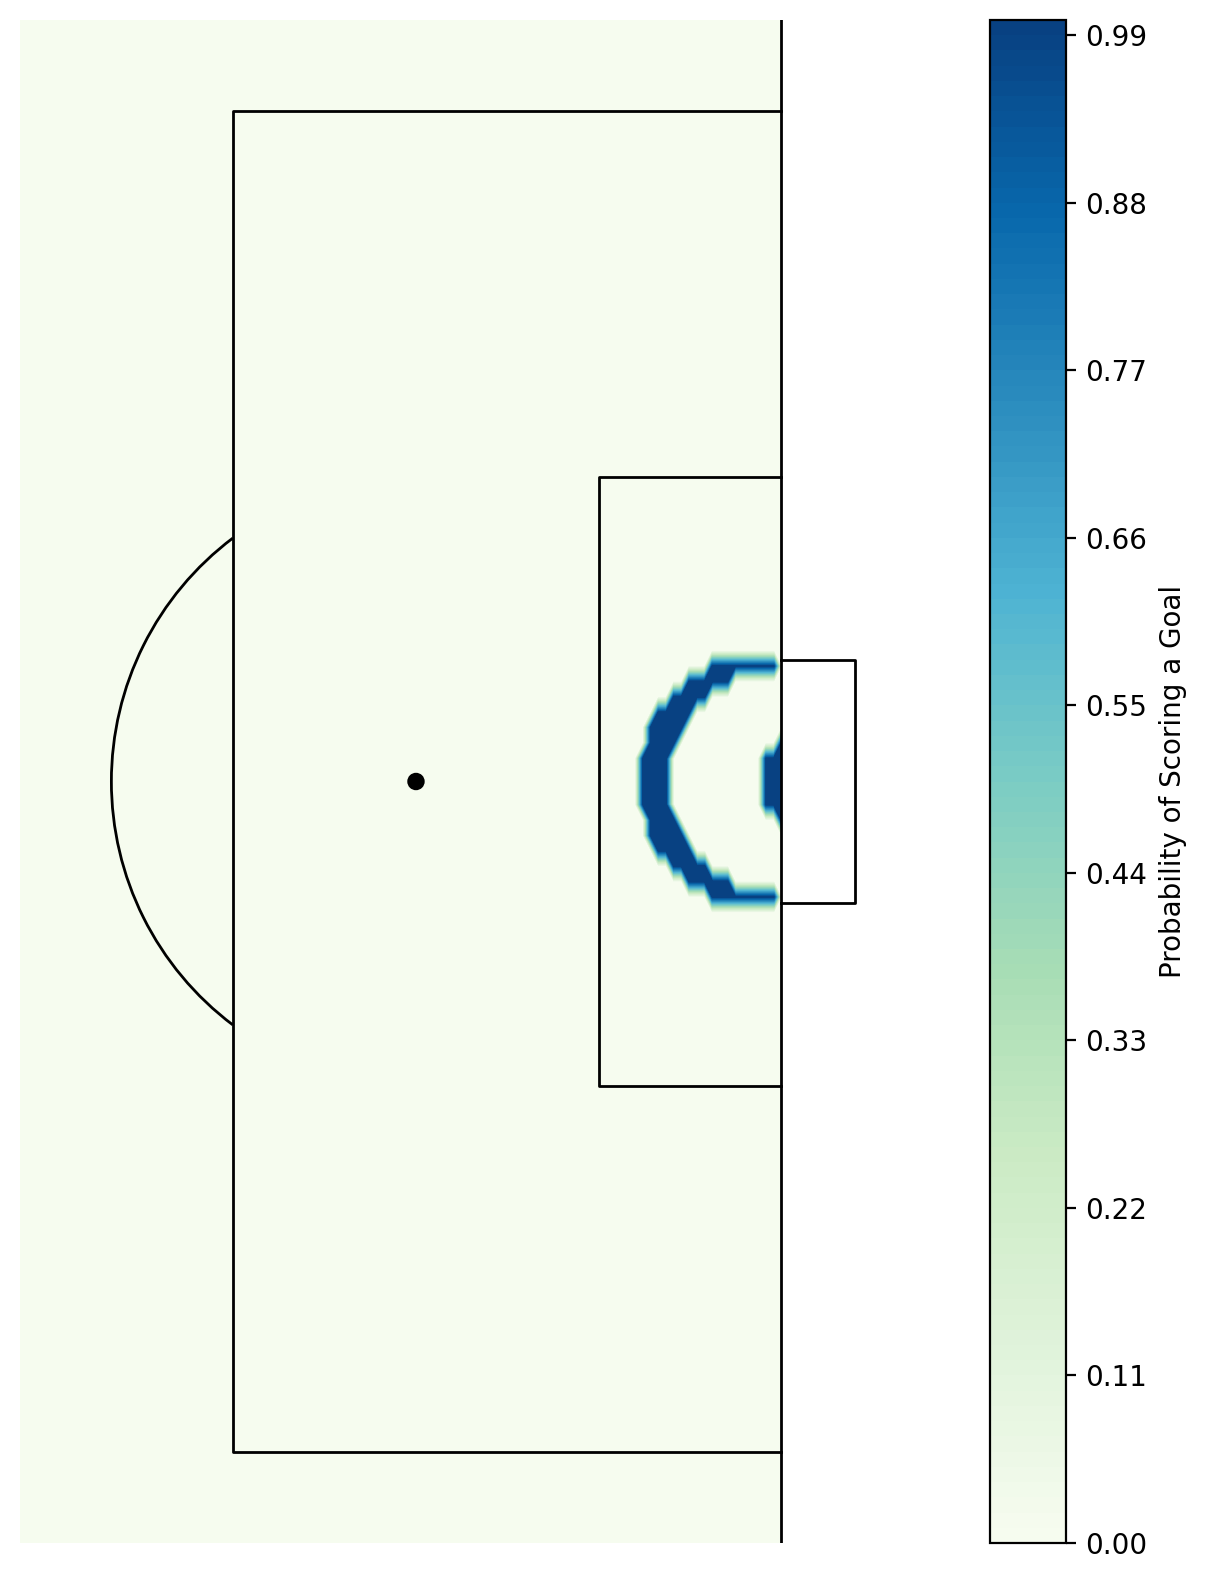

In [23]:
# Plot
x_values = np.linspace(95, 120, 100)  # Increase the number of points for finer resolution
y_values = np.linspace(15, 65, 100)   # Increase the number of points for finer resolution

xx, yy = np.meshgrid(x_values, y_values)
grid_points = np.c_[xx.ravel(), yy.ravel()]
full_grid_points = np.array([[calculate_dist(x, y), calculate_angle(x, y), 0, 0, 0, 0, 0, 1, 0] for x, y in grid_points])

# Calculate predictions instead of probabilities
goal_predictions = log_model.predict(full_grid_points)

# Clip values to be within 0 and 1
goal_predictions = np.clip(goal_predictions, 0, 1)

goal_pred_matrix = goal_predictions.reshape(xx.shape)

fig, ax = plt.subplots(figsize=(12, 8))
pitch = Pitch(half=True, goal_type='box', line_zorder=2, line_color='black', linewidth=1)
pitch.draw(ax=ax)
contour = ax.contourf(xx, yy, goal_pred_matrix, cmap='GnBu', levels=100, zorder=1, vmin=0, vmax=1)  # Increase levels for smoother gradient
fig.colorbar(contour, ax=ax, label='Probability of Scoring a Goal')
ax.set_xlim(95, 123)
ax.set_ylim(15, 65)
# Adjust layout and save the figure before plt.show()
plt.tight_layout()
plt.savefig('img_models/log_model_heatmap.png', bbox_inches='tight')
plt.show()

## Linear Regression

In [24]:
linear_model = make_pipeline(PolynomialFeatures(2), BayesianRidge())
linear_model.fit(X_train, y_train)

# Use KFold for regression tasks
cv = StratifiedKFold(n_splits=5)

# Use an appropriate scoring metric for regression, e.g., 'neg_mean_squared_error'
cv_score_lin = cross_val_score(linear_model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error').mean()
# Convert back to positive mean squared error for interpretability
cv_score_lin = -cv_score_lin
print(f'Cross-Validated Mean Squared Error: {cv_score_lin}')

# Predictions
y_pred = linear_model.predict(X_test)

# Evaluate the model
mae_linear = mean_absolute_error(y_test, y_pred)
mse_linear = mean_squared_error(y_test, y_pred)
rmse_linear = np.sqrt(mse_linear)  # Calculating RMSE
r2_linear = r2_score(y_test, y_pred)

# Print the evaluation metrics
print(f'Mean Absolute Error (MAE): {mae_linear}')
print(f'Mean Squared Error (MSE): {mse_linear}')
print(f'Root Mean Squared Error (RMSE): {rmse_linear}')
print(f'R-squared (R²): {r2_linear}')

Cross-Validated Mean Squared Error: 0.08071456641924647
Mean Absolute Error (MAE): 0.16149679739657735
Mean Squared Error (MSE): 0.08050372396172085
Root Mean Squared Error (RMSE): 0.2837317817265469
R-squared (R²): 0.15980351693503192


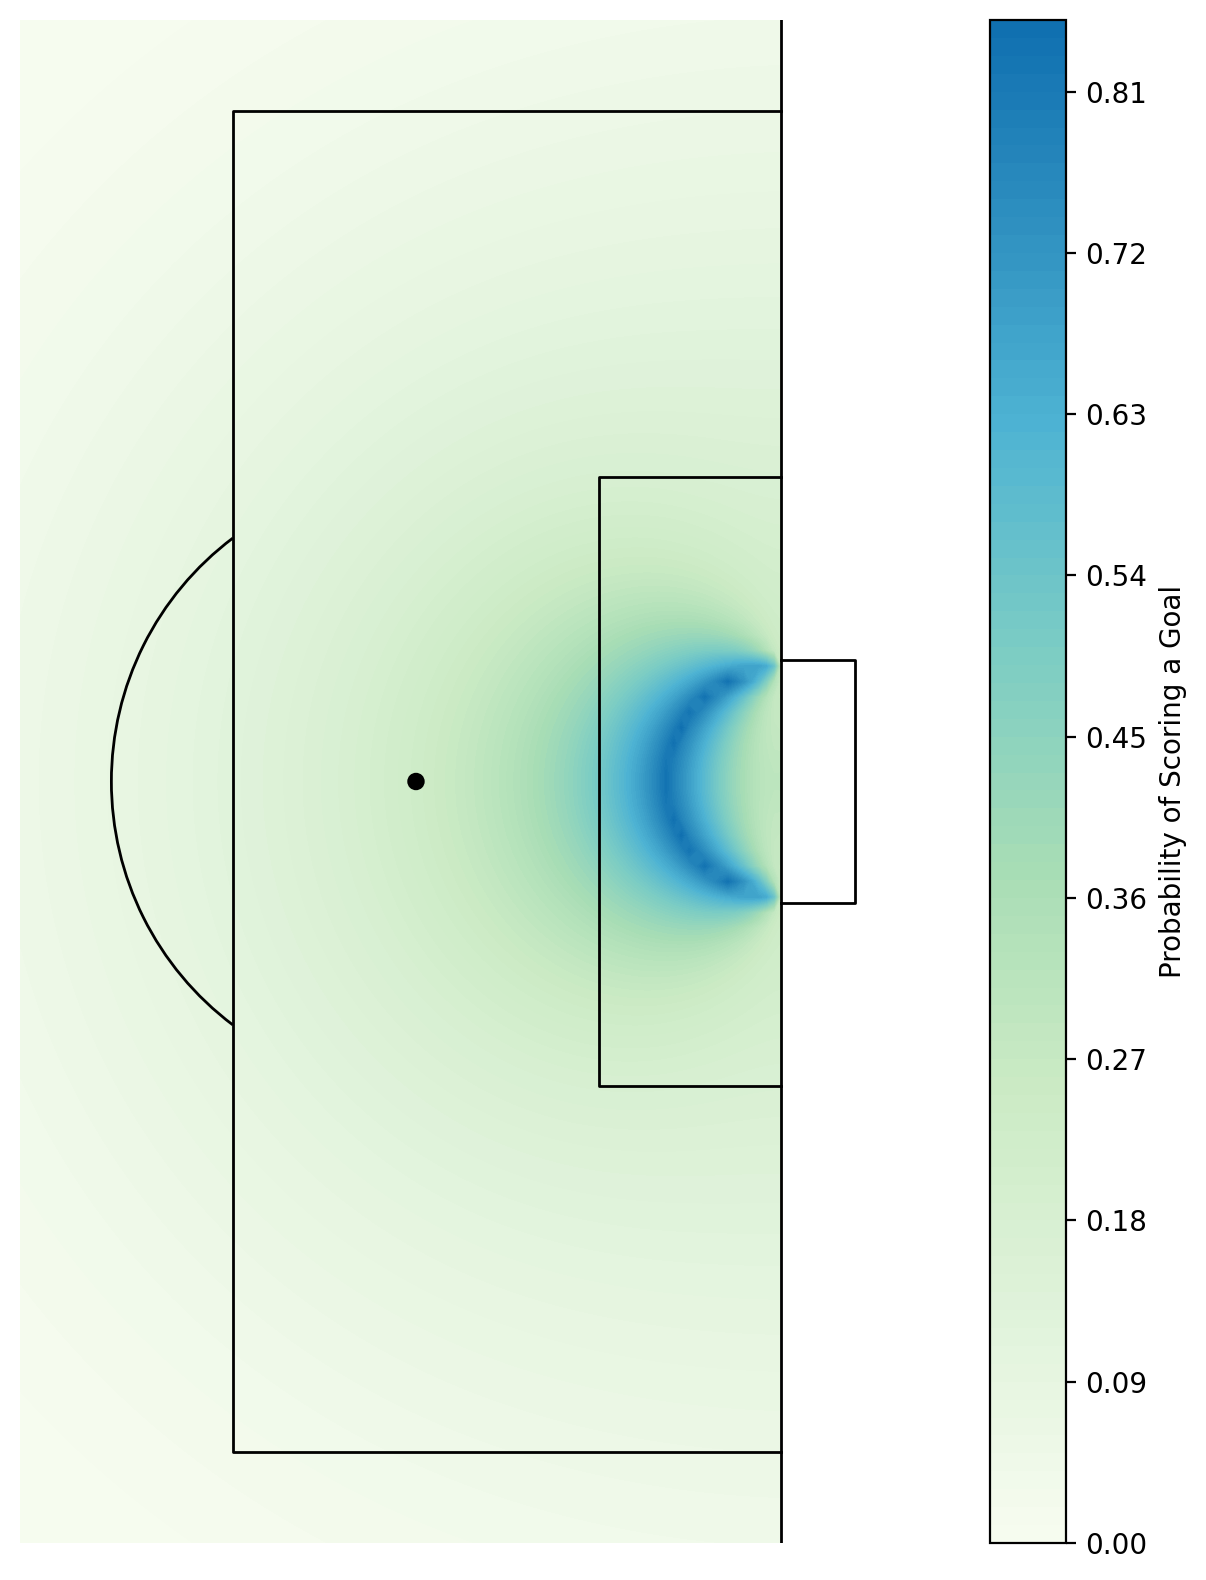

In [25]:
# Plot
x_values = np.linspace(95, 120, 100)  # Increase the number of points for finer resolution
y_values = np.linspace(15, 65, 100)   # Increase the number of points for finer resolution

xx, yy = np.meshgrid(x_values, y_values)
grid_points = np.c_[xx.ravel(), yy.ravel()]
full_grid_points = np.array([[calculate_dist(x, y), calculate_angle(x, y), 0, 0, 0, 0, 0, 1, 0] for x, y in grid_points])

# Calculate predictions instead of probabilities
goal_predictions = linear_model.predict(full_grid_points)

# Clip values to be within 0 and 1
goal_predictions = np.clip(goal_predictions, 0, 1)

goal_pred_matrix = goal_predictions.reshape(xx.shape)

fig, ax = plt.subplots(figsize=(12, 8))
pitch = Pitch(half=True, goal_type='box', line_zorder=2, line_color='black', linewidth=1)
pitch.draw(ax=ax)
contour = ax.contourf(xx, yy, goal_pred_matrix, cmap='GnBu', levels=100, zorder=1, vmin=0, vmax=1)  # Increase levels for smoother gradient
fig.colorbar(contour, ax=ax, label='Probability of Scoring a Goal')
ax.set_xlim(95, 123)
ax.set_ylim(15, 65)
# Adjust layout and save the figure before plt.show()
plt.tight_layout()
plt.savefig('img_models/linear_model_heatmap.png', bbox_inches='tight')
plt.show()

## XGBoost

In [26]:
# Initialize the XGBoost model for regression
xgb_model = XGBRegressor(objective='reg:squarederror', eval_metric='logloss')

# Use K-Fold for cross-validation, appropriate for regression tasks
cv = KFold(n_splits=5)

# Cross-validation across the entire dataset for a general performance estimation using MSE
cv_mse_xgb = -cross_val_score(xgb_model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error').mean()
print(f'Cross-Validated Mean Squared Error: {cv_mse_xgb}')

# Fit the model on the training data
xgb_model.fit(X_train, y_train)

# Predictions
y_pred = xgb_model.predict(X_test)

# Evaluate the model using regression metrics
mae_xgb = mean_absolute_error(y_test, y_pred)
mse_xgb = mean_squared_error(y_test, y_pred)
rmse_xgb = np.sqrt(mse_xgb)  # Calculating RMSE
r2_xgb = r2_score(y_test, y_pred)

# Print the evaluation metrics for regression
print(f'Mean Absolute Error (MAE): {mae_xgb}')
print(f'Mean Squared Error (MSE): {mse_xgb}')
print(f'Root Mean Squared Error (RMSE): {rmse_xgb}')
print(f'R-squared (R²): {r2_xgb}')

Cross-Validated Mean Squared Error: 0.08269715863968846
Mean Absolute Error (MAE): 0.15288185285562103
Mean Squared Error (MSE): 0.07512456259405301
Root Mean Squared Error (RMSE): 0.2740886035464682
R-squared (R²): 0.2159444286908967


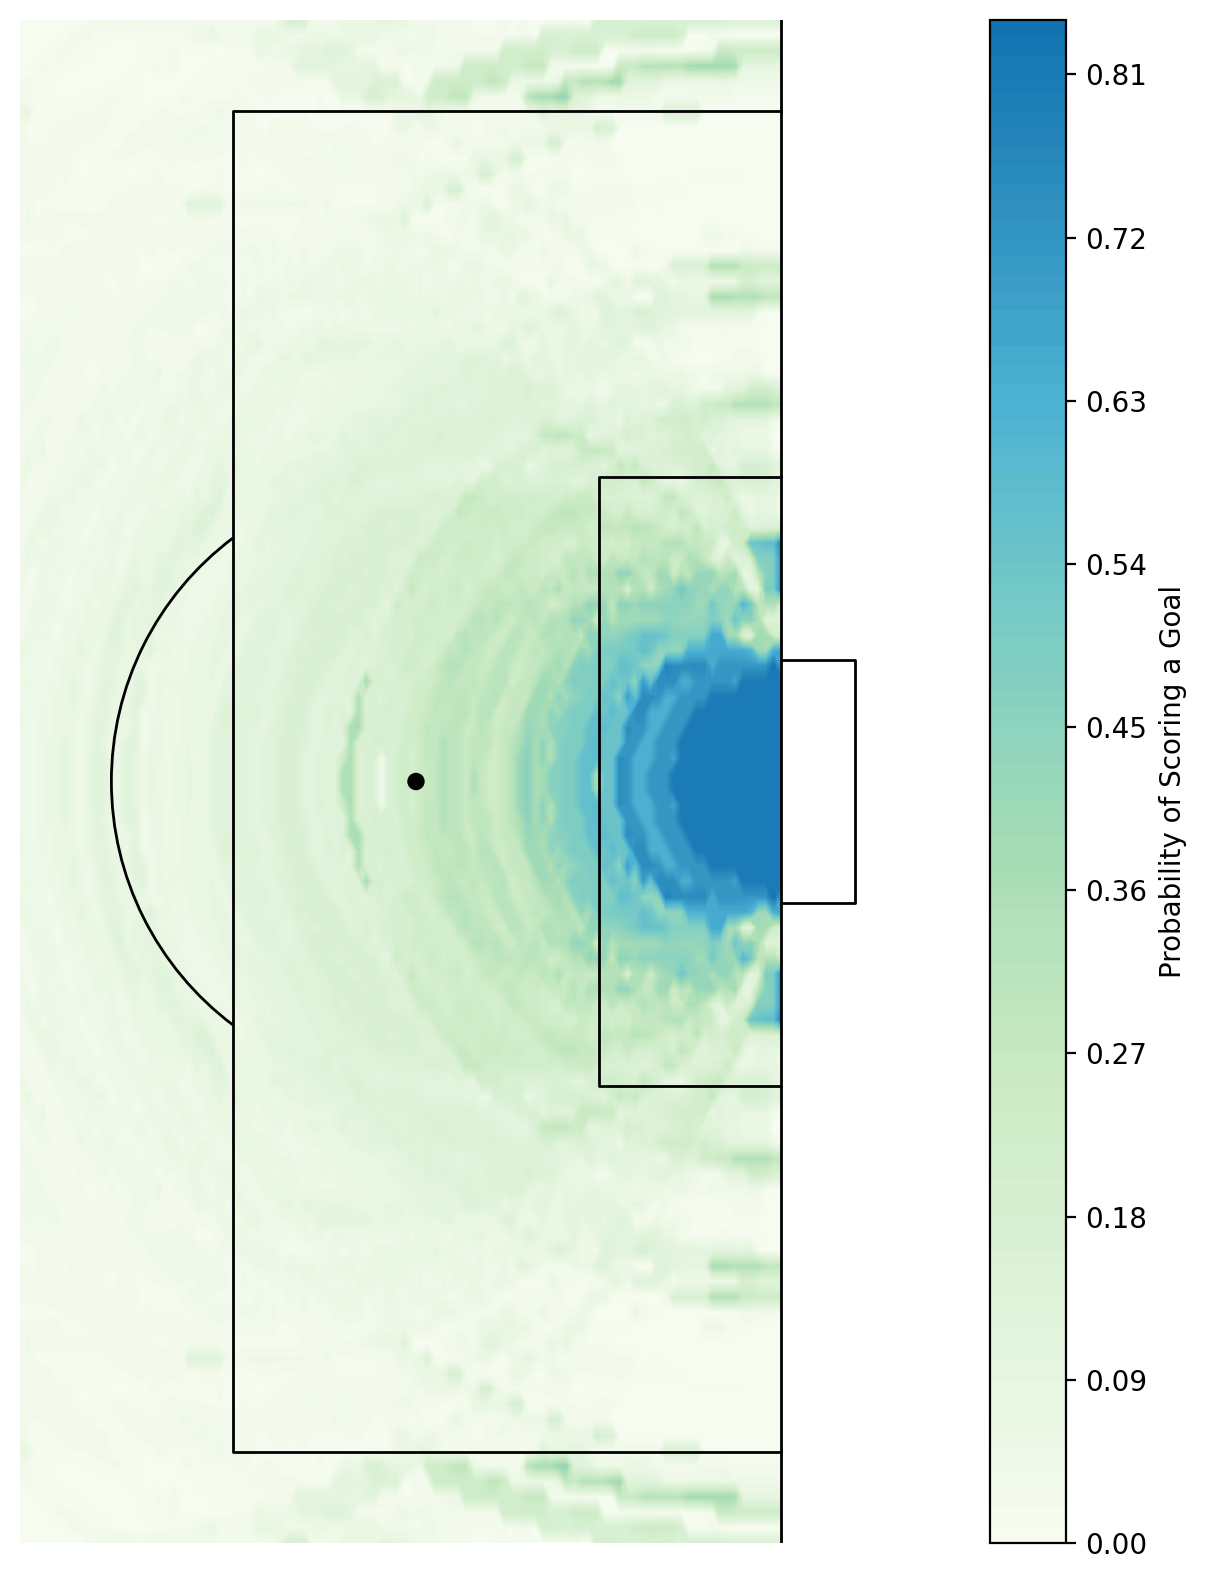

In [27]:
# Plot
x_values = np.linspace(95, 120, 100)  # Increase the number of points for finer resolution
y_values = np.linspace(15, 65, 100)   # Increase the number of points for finer resolution

xx, yy = np.meshgrid(x_values, y_values)
grid_points = np.c_[xx.ravel(), yy.ravel()]
full_grid_points = np.array([[calculate_dist(x, y), calculate_angle(x, y), 0, 0, 0, 0, 0, 1, 0] for x, y in grid_points])

# Calculate predictions instead of probabilities
goal_predictions = xgb_model.predict(full_grid_points)

# Clip values to be within 0 and 1
goal_predictions = np.clip(goal_predictions, 0, 1)

goal_pred_matrix = goal_predictions.reshape(xx.shape)

fig, ax = plt.subplots(figsize=(12, 8))
pitch = Pitch(half=True, goal_type='box', line_zorder=2, line_color='black', linewidth=1)
pitch.draw(ax=ax)
contour = ax.contourf(xx, yy, goal_pred_matrix, cmap='GnBu', levels=100, zorder=1, vmin=0, vmax=1)  # Increase levels for smoother gradient
fig.colorbar(contour, ax=ax, label='Probability of Scoring a Goal')
ax.set_xlim(95, 123)
ax.set_ylim(15, 65)
# Adjust layout and save the figure before plt.show()
plt.tight_layout()
plt.savefig('img_models/xgb_model_heatmap.png', bbox_inches='tight')
plt.show()

## Catboost

In [28]:
# Initialize the catboost model for regression
from catboost import CatBoostRegressor
cat_model = CatBoostRegressor(iterations=100, learning_rate=0.1, depth=5, loss_function='RMSE')

# Use K-Fold for cross-validation, appropriate for regression tasks
cv = KFold(n_splits=5)

# Cross-validation across the entire dataset for a general performance estimation using MSE
cv_mse_cat = -cross_val_score(cat_model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error').mean()
print(f'Cross-Validated Mean Squared Error: {cv_mse_cat}')

# Fit the model on the training data
cat_model.fit(X_train, y_train, verbose=False)

# Predictions
y_pred = cat_model.predict(X_test)

# Evaluate the model using regression metrics
mae_cat = mean_absolute_error(y_test, y_pred)
mse_cat = mean_squared_error(y_test, y_pred)
rmse_cat = np.sqrt(mse_cat)  # Calculating RMSE
r2_cat = r2_score(y_test, y_pred)

# Print the evaluation metrics for regression
print(f'Mean Absolute Error (MAE): {mae_cat}')
print(f'Mean Squared Error (MSE): {mse_cat}')
print(f'Root Mean Squared Error (RMSE): {rmse_cat}')
print(f'R-squared (R²): {r2_cat}')

0:	learn: 0.3069243	total: 59.7ms	remaining: 5.91s
1:	learn: 0.3034567	total: 61.8ms	remaining: 3.03s
2:	learn: 0.3005593	total: 63.4ms	remaining: 2.05s
3:	learn: 0.2981500	total: 65.1ms	remaining: 1.56s
4:	learn: 0.2961666	total: 66.8ms	remaining: 1.27s
5:	learn: 0.2943862	total: 68.5ms	remaining: 1.07s
6:	learn: 0.2929219	total: 70.4ms	remaining: 935ms
7:	learn: 0.2917020	total: 72.3ms	remaining: 832ms
8:	learn: 0.2906385	total: 74.2ms	remaining: 750ms
9:	learn: 0.2898121	total: 76.2ms	remaining: 686ms
10:	learn: 0.2891330	total: 78ms	remaining: 631ms
11:	learn: 0.2884445	total: 79.9ms	remaining: 586ms
12:	learn: 0.2878999	total: 81.6ms	remaining: 546ms
13:	learn: 0.2874425	total: 83.4ms	remaining: 512ms
14:	learn: 0.2870406	total: 85.4ms	remaining: 484ms
15:	learn: 0.2866912	total: 87.3ms	remaining: 459ms
16:	learn: 0.2864358	total: 89.6ms	remaining: 438ms
17:	learn: 0.2862116	total: 91.7ms	remaining: 418ms
18:	learn: 0.2859596	total: 93.8ms	remaining: 400ms
19:	learn: 0.2857490	tot

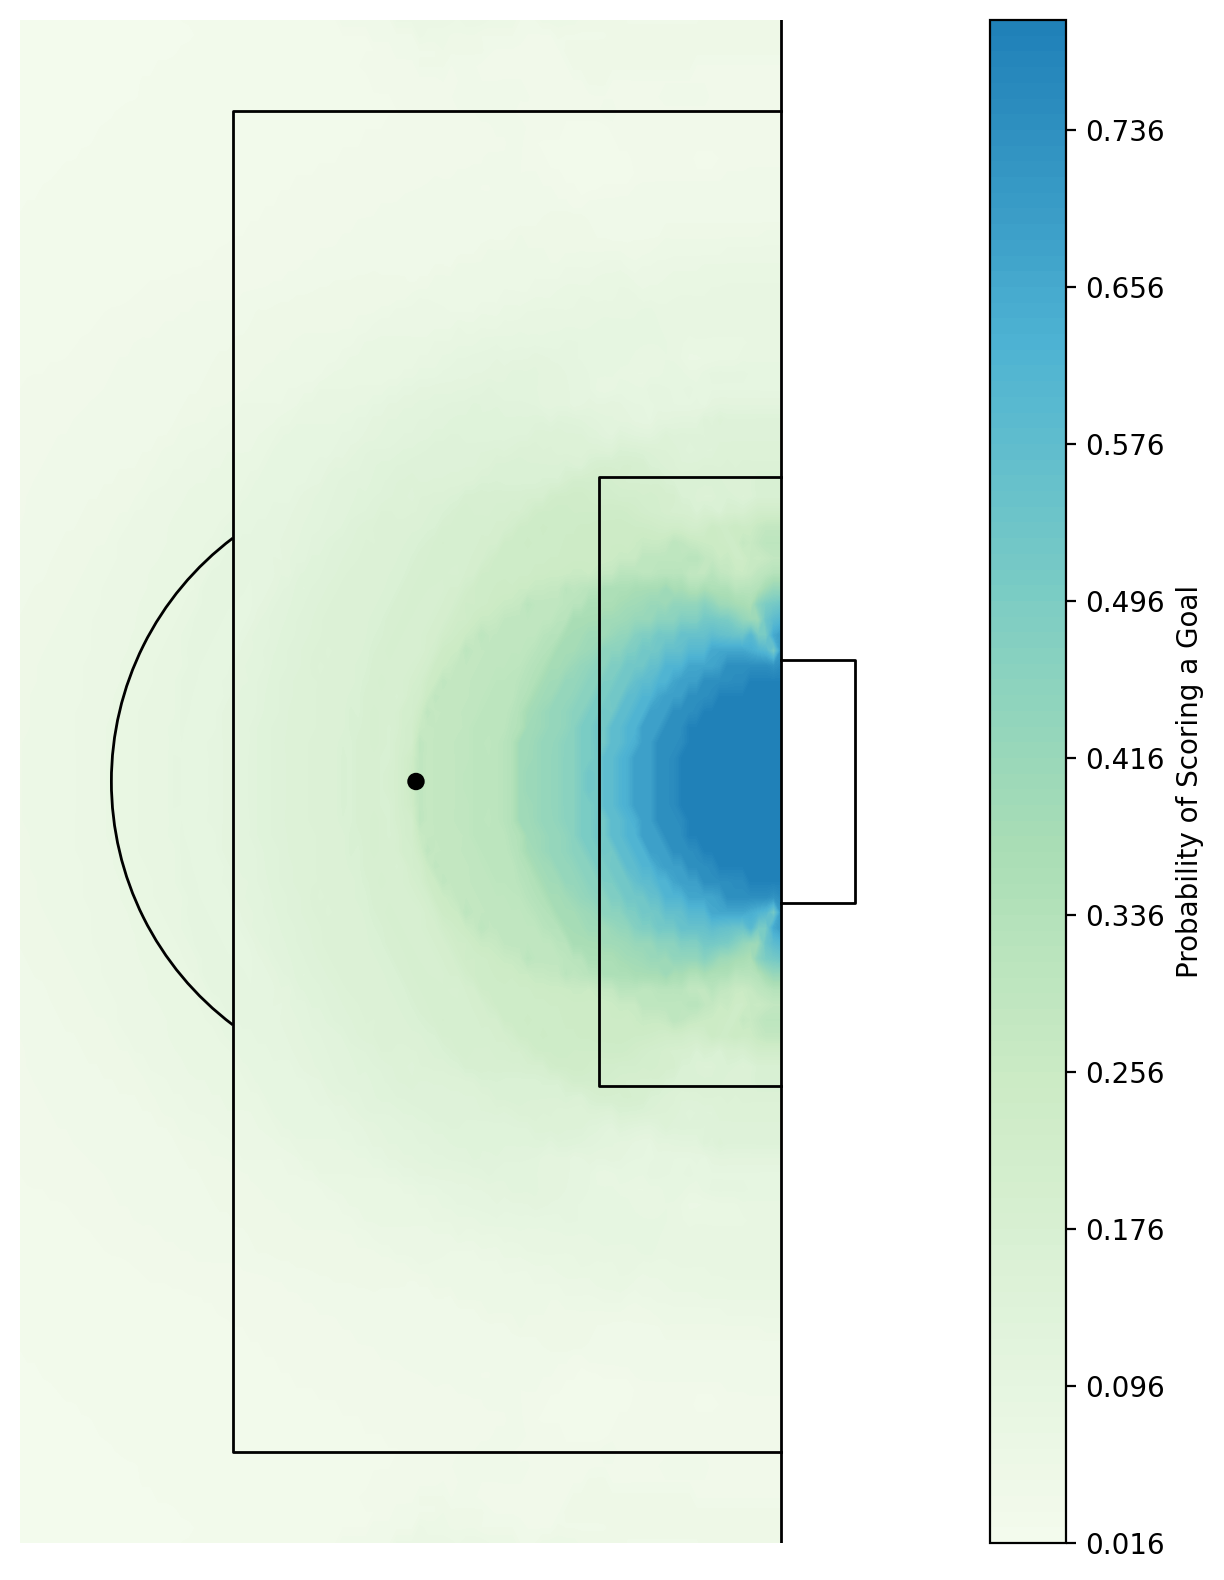

In [29]:
# Plot
x_values = np.linspace(95, 120, 100)  # Increase the number of points for finer resolution
y_values = np.linspace(15, 65, 100)   # Increase the number of points for finer resolution

xx, yy = np.meshgrid(x_values, y_values)
grid_points = np.c_[xx.ravel(), yy.ravel()]
full_grid_points = np.array([[calculate_dist(x, y), calculate_angle(x, y), 0, 0, 0, 0, 0, 1, 0] for x, y in grid_points])

# Calculate predictions instead of probabilities
goal_predictions = cat_model.predict(full_grid_points)

# Clip values to be within 0 and 1
goal_predictions = np.clip(goal_predictions, 0, 1)

goal_pred_matrix = goal_predictions.reshape(xx.shape)

fig, ax = plt.subplots(figsize=(12, 8))
pitch = Pitch(half=True, goal_type='box', line_zorder=2, line_color='black', linewidth=1)
pitch.draw(ax=ax)
contour = ax.contourf(xx, yy, goal_pred_matrix, cmap='GnBu', levels=100, zorder=1, vmin=0, vmax=1)  # Increase levels for smoother gradient
fig.colorbar(contour, ax=ax, label='Probability of Scoring a Goal')
ax.set_xlim(95, 123)
ax.set_ylim(15, 65)
# Adjust layout and save the figure before plt.show()
plt.tight_layout()
plt.savefig('img_models/cat_model_heatmap.png', bbox_inches='tight')
plt.show()

## Comparing Model Performance

In [33]:
# Data for regression models
types_of_models = ['SVR', 'Decision Tree', 'Random Forest', 'Neural Network', 'Linear Regression', 'XGBoost', 'CatBoost']
cv_mse_values = [cv_mse_svm, cv_mse_dt, cv_mse_rm, cv_mse_nn, cv_score_lin, cv_mse_xgb, cv_mse_cat]
mae_values = [mae_svm, mae_dt, mae_rm, mae_nn, mae_linear, mae_xgb, mae_cat]
mse_values = [mse_svm, mse_dt, mse_rm, mse_nn, mse_linear, mse_xgb, mse_cat]
rmse_values = [rmse_svm, rmse_dt, rmse_rm, rmse_nn, rmse_linear, rmse_xgb, rmse_cat]
r2_values = [r2_svm, r2_dt, r2_rm, r2_nn, r2_linear, r2_xgb, r2_cat]

df = pd.DataFrame({'Model': types_of_models, 'Cross-Validated MSE': cv_mse_values, 'MAE': mae_values, 'MSE': mse_values, 'RMSE': rmse_values, 'R²': r2_values})

# All the scores apart from R2, should be as low as possible
# Create a score with all the metrics combined
# Create a new df with the scores and R2, only keep columns model, score and R2
df['Score'] = df['Cross-Validated MSE'] + df['MAE'] + df['MSE'] + df['RMSE']
df_score = df[['Model', 'Score', 'R²']]
df_score

,Model,Score,R²
0,SVR,0.645927,0.096251
1,Decision Tree,0.605484,0.161414
2,Random Forest,0.603781,0.166099
3,Neural Network,0.599477,0.149309
4,Linear Regression,0.606447,0.159804
5,XGBoost,0.584792,0.215944
6,CatBoost,0.600696,0.171227


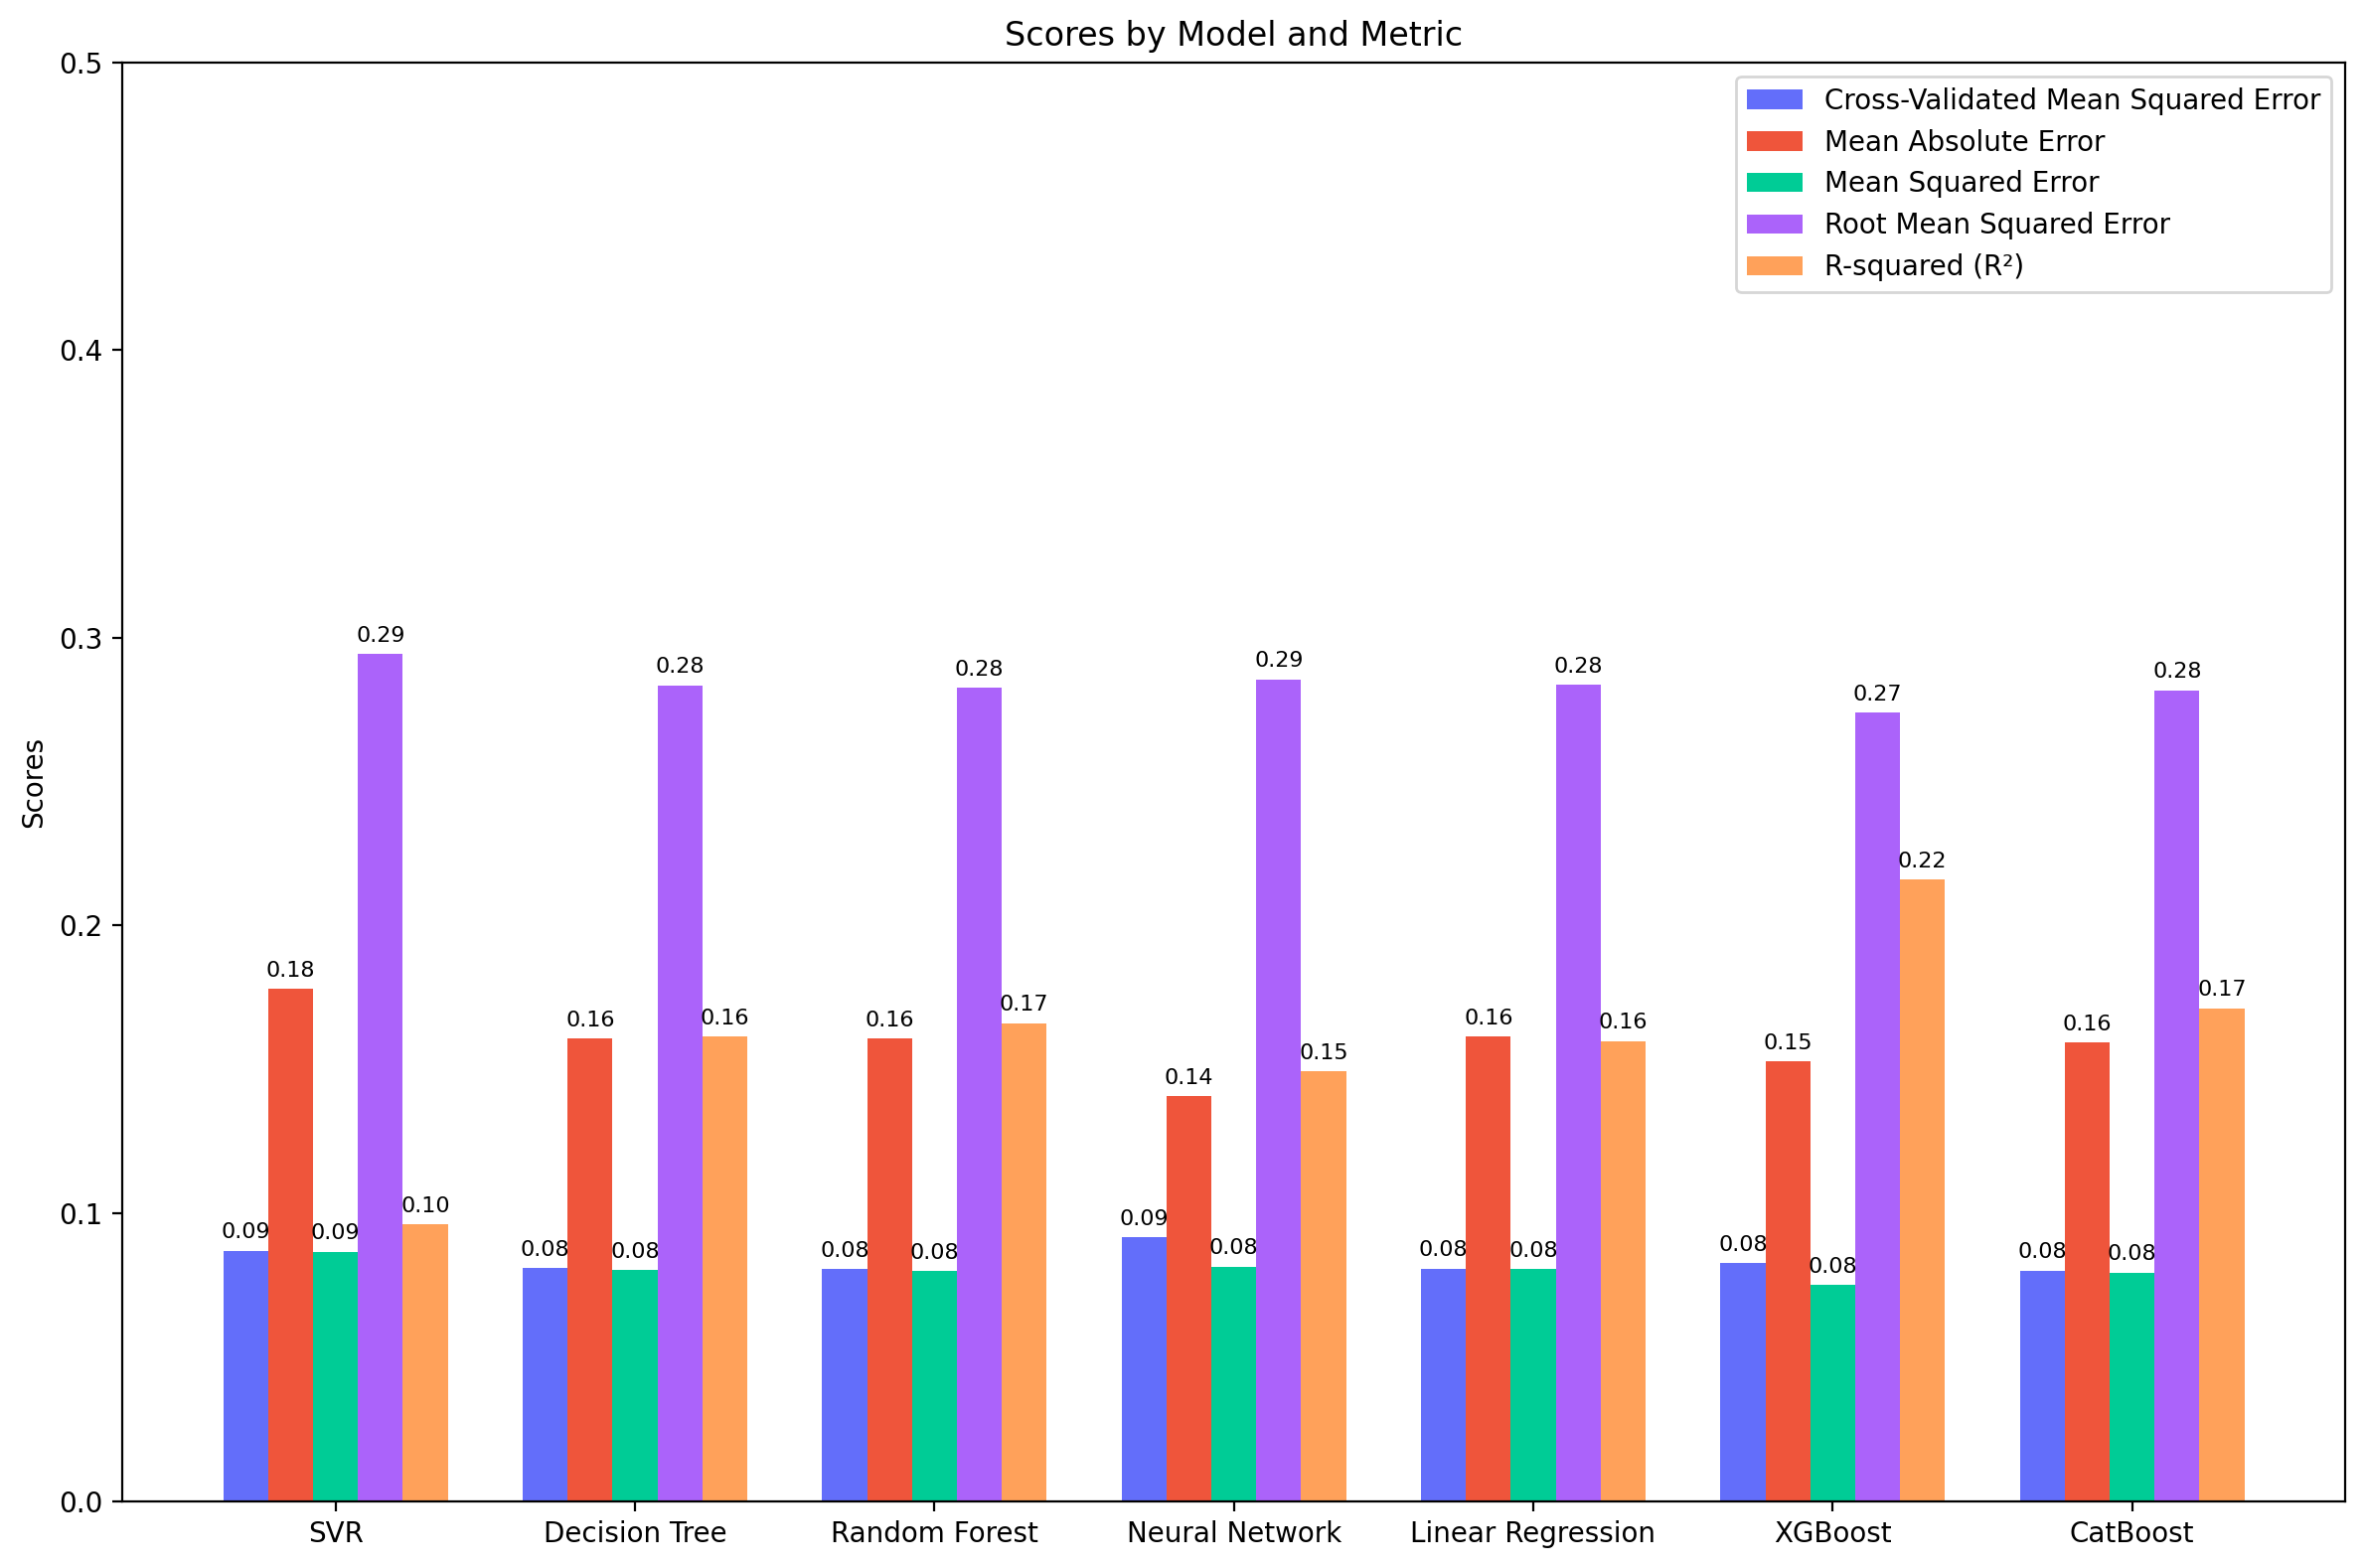

In [34]:
fig, ax = plt.subplots(figsize=(12, 8))
x = np.arange(len(types_of_models))  # the label locations
width = 0.15  # the width of the bars

# Use Plotly's qualitative color map
cmap = px.colors.qualitative.Plotly


# Plot each metric with direct color assignment from cmap
rects1 = ax.bar(x - 2 * width, df['Cross-Validated MSE'], width, label='Cross-Validated Mean Squared Error', color=cmap[0])
rects2 = ax.bar(x - width, df['MAE'], width, label='Mean Absolute Error', color=cmap[1])
rects3 = ax.bar(x, df['MSE'], width, label='Mean Squared Error', color=cmap[2])
rects4 = ax.bar(x + width, df['RMSE'], width, label='Root Mean Squared Error', color=cmap[3])
rects5 = ax.bar(x + 2 * width, df['R²'], width, label='R-squared (R²)', color=cmap[4])

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores by Model and Metric')
ax.set_xticks(x)
ax.set_xticklabels(types_of_models)
ax.legend()
ax.set_ylim(0, 0.5)

# Add value labels on top of the bars
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

add_labels(rects1)
add_labels(rects2)
add_labels(rects3)
add_labels(rects4)
add_labels(rects5)

fig.tight_layout()
plt.savefig('img_models/model_comparison3.png')
plt.show()

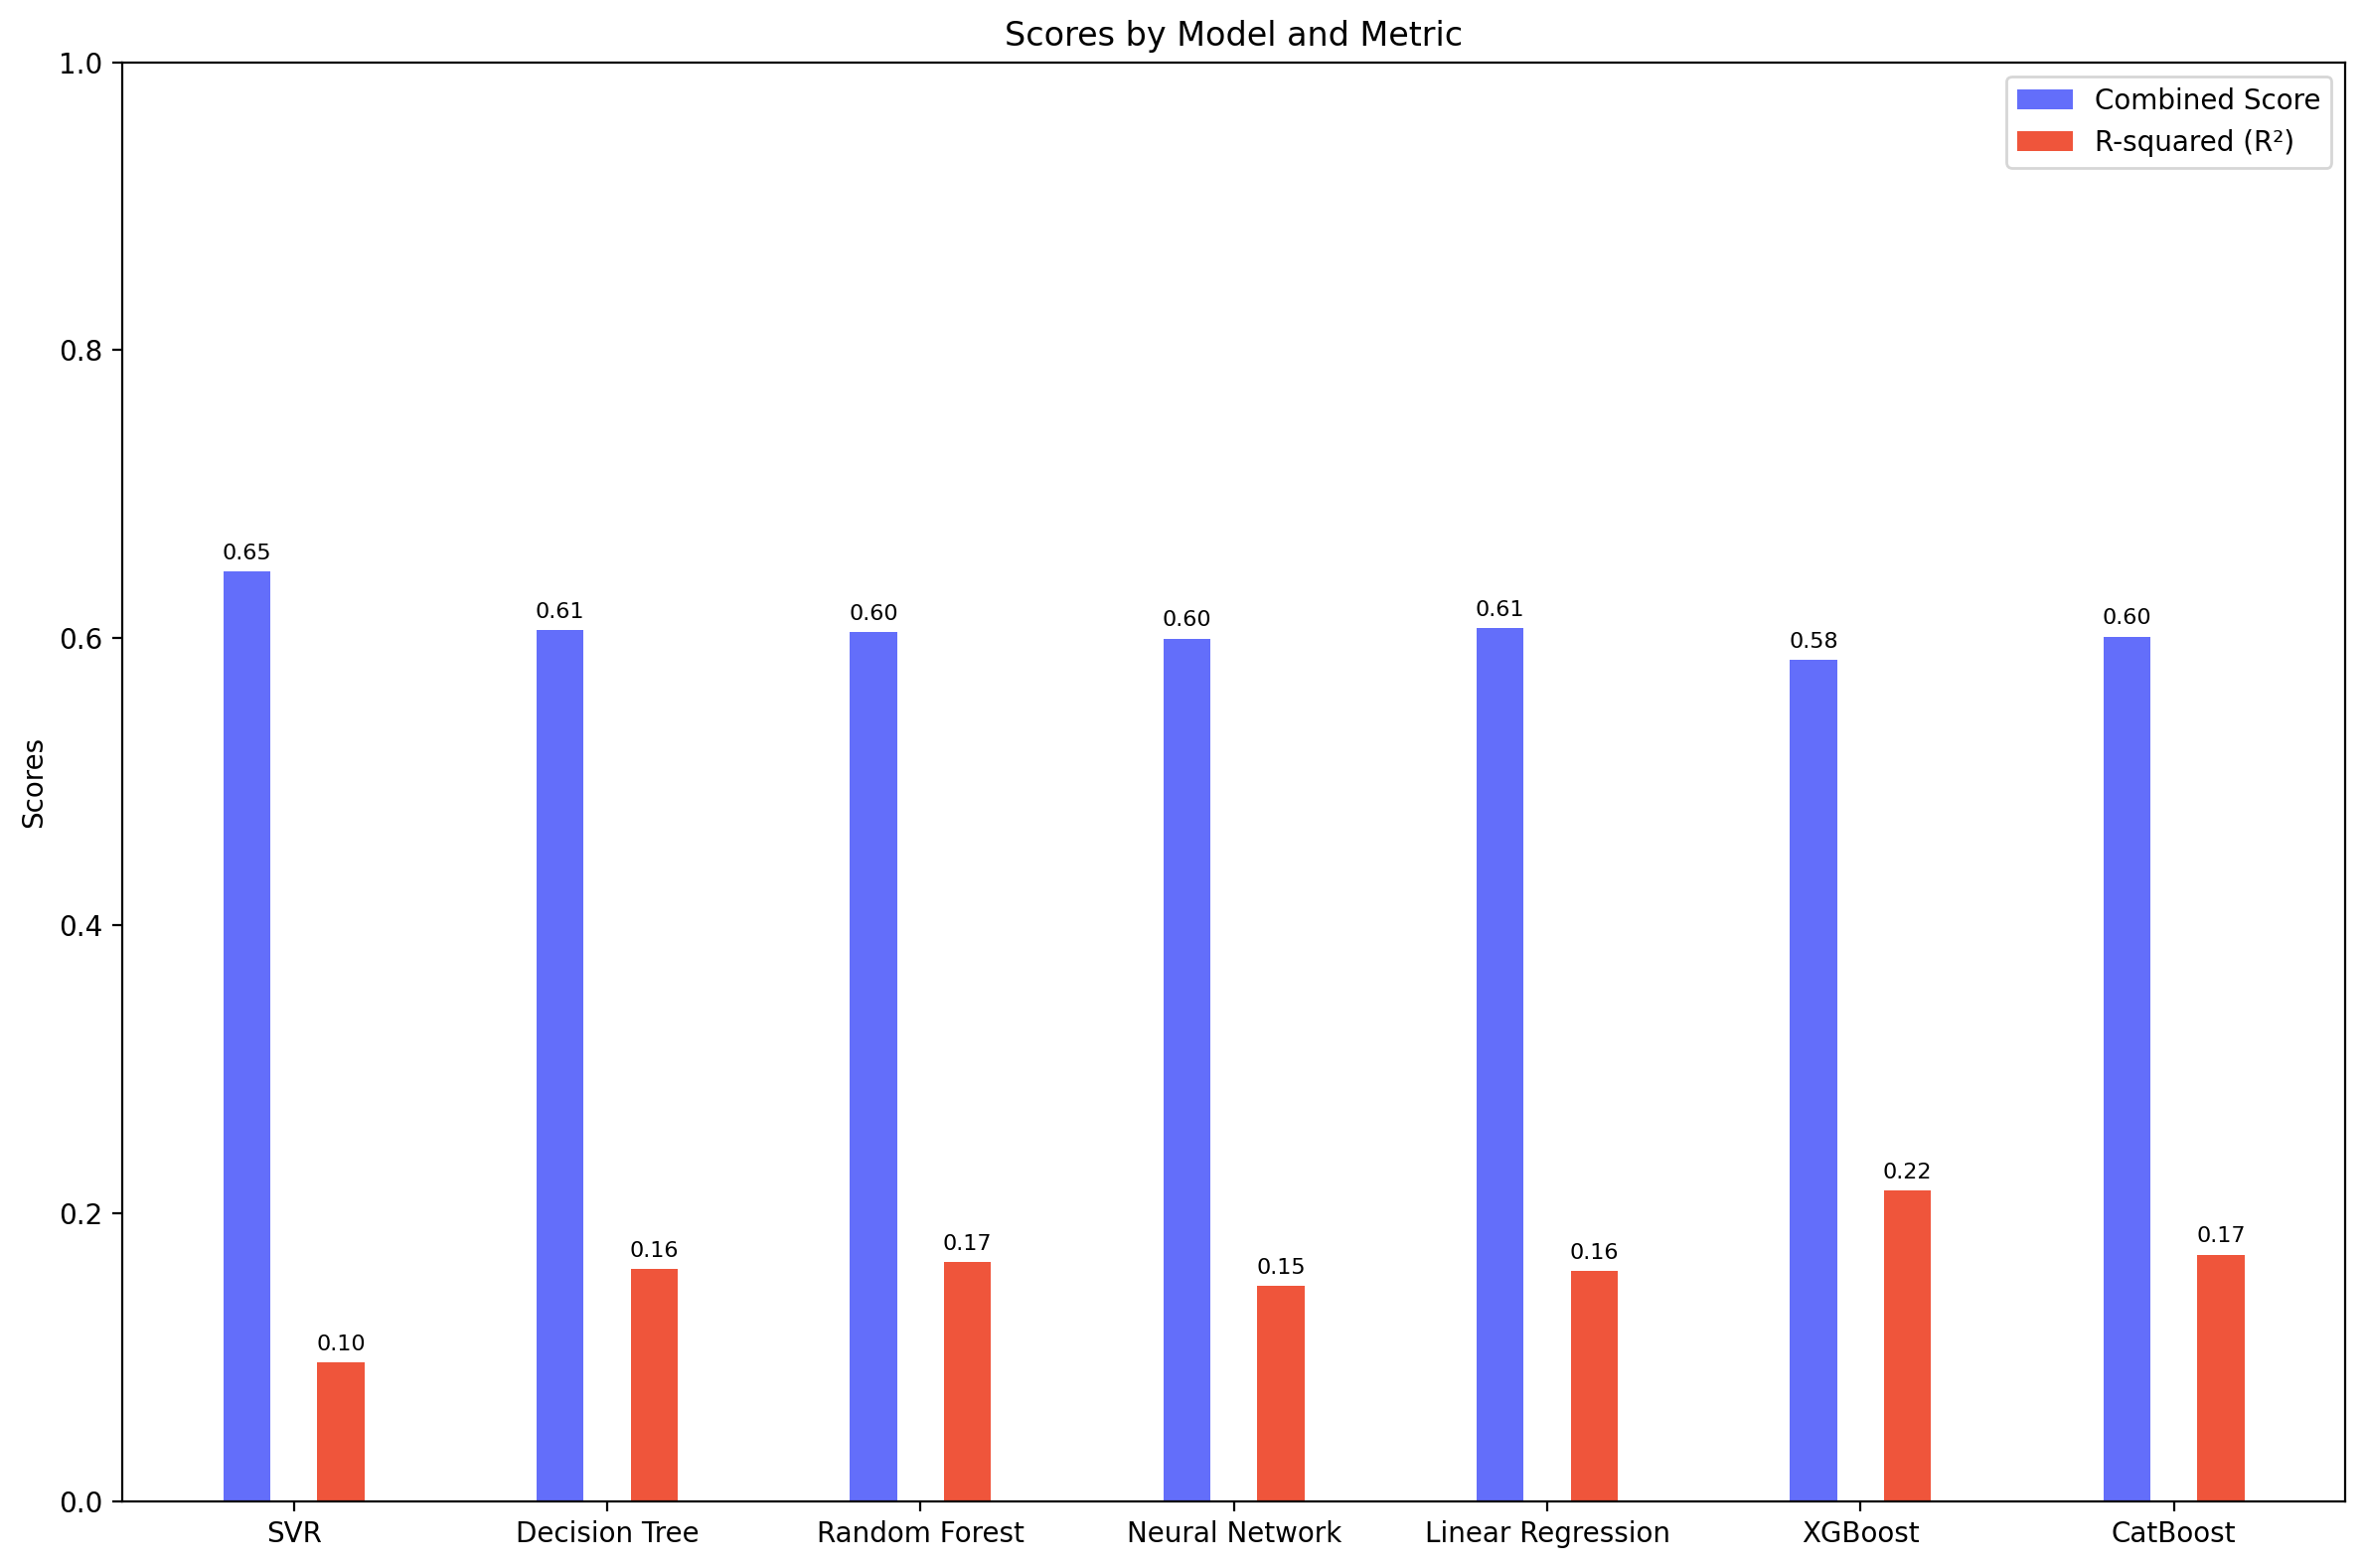

In [37]:
fig, ax = plt.subplots(figsize=(12, 8))
x = np.arange(len(types_of_models))  # the label locations
width = 0.15  # the width of the bars

# Use Plotly's qualitative color map
cmap = px.colors.qualitative.Plotly

# Plot each metric with direct color assignment from cmap
rects1 = ax.bar(x - width, df_score['Score'], width, label='Combined Score', color=cmap[0])
rects2 = ax.bar(x + width, df_score['R²'], width, label='R-squared (R²)', color=cmap[1])

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores by Model and Metric')
ax.set_xticks(x)
ax.set_xticklabels(types_of_models)
ax.legend()
ax.set_ylim(0, 1)

# Add value labels on top of the bars
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

add_labels(rects1)
add_labels(rects2)

fig.tight_layout()
plt.savefig('img_models/model_comparison3.png')
plt.show()